<a href="https://colab.research.google.com/github/cyndroy/DP_Skin_Cancer_Classification_using_PATE/blob/master/DP_PATE_SkinCancer(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install syft

In [21]:
import numpy as np
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import time, os, random

# libary from pysyft needed to perform pate analysis
from syft.frameworks.torch.dp import pate

# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
%cd '/content/drive/My Drive/Colab Notebooks/CancerDataset'

/content/drive/My Drive/Colab Notebooks/CancerDataset


In [3]:
class SkinCancerDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):

        benign_list = [[os.path.join(benign_path, filename),'0'] for filename in os.listdir(benign_path)] 
        malignant_list = [[os.path.join(malignant_path, filename),'1'] for filename in os.listdir(malignant_path)]
       
        self.img_list = []
        self.img_list = benign_list + malignant_list
        random.shuffle(self.img_list)

        self.transform = transform
      

    def __len__(self):
        return len(self.img_list)   

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx][1])
        return image, label

In [4]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset = SkinCancerDataset(benign_path = './data/train/benign',
                             malignant_path = './data/train/malignant', transform = data_transforms)

testset = SkinCancerDataset(benign_path = './data/test/benign',
                             malignant_path = './data/test/malignant' , transform = data_transforms)

validset = SkinCancerDataset(benign_path = './data/valid/benign',
                             malignant_path = './data/valid/malignant', transform = data_transforms)

len(trainset),len(testset),len(validset)

(2560, 584, 146)

 Image Size torch.Size([16, 3, 224, 224])
 Image Size torch.Size([3, 224, 224])


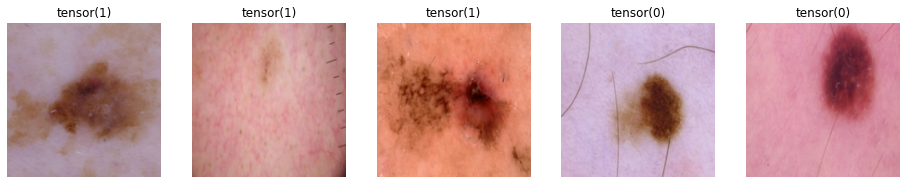

In [5]:
batchsize=16
data_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True)

import matplotlib.pyplot as plt

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    #print(type(image))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

# Displaying Images and other info about the train set
ii=0
images, labels = next(iter(data_loader))
print(" Image Size",images.size())
print(" Image Size",images[ii].size())

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii])
    imshow(images[ii], ax=ax, normalize=True)

In [6]:
# TEACHERS
#divide train set among teachers and create dataloaders for valid and trainsets
num_teachers = 5
valid_per = 0.2 #20% for validation
batch_size = 32

def teacher_dataloaders(trainset=trainset, num_teachers=num_teachers, batch_size=batch_size, valid_per = 0.2):
  trainloaders = []
  validloaders = []
  teacher_data_len = len(trainset) // num_teachers

  # create a list of shuffled indices
  my_list = random.sample(range(1,len(trainset)), len(trainset)-1)
  random.shuffle(my_list)

  for i in range(num_teachers):
    # get particular subset of data
    indice = my_list[i*teacher_data_len: (i+1)*teacher_data_len]
    data_subset = Subset(trainset, indice)

    # split into train and validation set
    valid_size = int(len(data_subset) * valid_per)
    train_size = len(data_subset) - valid_size
    train_subset, valid_subset = torch.utils.data.random_split(data_subset, [train_size,valid_size])

    #create data loaders
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
    validloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

    #add dataloaders to list
    trainloaders.append(trainloader)
    validloaders.append(validloader)

  return trainloaders, validloaders

# creating dataloaders
trainloaders, validloaders = teacher_dataloaders()
len(trainloaders), len(validloaders)

(5, 5)

In [7]:
#  # STUDENT
# split into train and validation set
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(15, 4)

In [8]:
#Teacher Model
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))

        #b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))       
        self.layer4 = layer4

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)

        return fc_out

In [9]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total

        # print training/validation statistics
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))

        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    return model

In [10]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 30

In [11]:
#Training teachers
# Training teachers
teacher_models = []
i = 1
for trainloader, validloader in zip(trainloaders, validloaders):
  print(" Training Teacher {}".format(i))
  teacher_model = train(epochs, trainloader, validloader, model, optimizer, criterion, True)
  teacher_models.append(teacher_model)
  i+=1
  print("="*40)

 Training Teacher 1
Epoch: 1 
	Train Loss: 24.482168 	Train Acc: 55.609756 
	Valid Loss: 23.498638 	Valid Acc: 60.784314
Epoch: 2 
	Train Loss: 11.817554 	Train Acc: 66.341463 
	Valid Loss: 11.870229 	Valid Acc: 66.666667
Epoch: 3 
	Train Loss: 4.672810 	Train Acc: 73.414634 
	Valid Loss: 4.799848 	Valid Acc: 74.509804
Epoch: 4 
	Train Loss: 3.356927 	Train Acc: 72.926829 
	Valid Loss: 3.469245 	Valid Acc: 72.549020
Epoch: 5 
	Train Loss: 2.095262 	Train Acc: 78.048780 
	Valid Loss: 2.065598 	Valid Acc: 71.568627
Epoch: 6 
	Train Loss: 1.715789 	Train Acc: 74.390244 
	Valid Loss: 2.551642 	Valid Acc: 74.509804
Epoch: 7 
	Train Loss: 1.238811 	Train Acc: 79.268293 
	Valid Loss: 1.368321 	Valid Acc: 77.450980
Epoch: 8 
	Train Loss: 1.024633 	Train Acc: 76.341463 
	Valid Loss: 1.089638 	Valid Acc: 81.372549
Epoch: 9 
	Train Loss: 0.812000 	Train Acc: 79.512195 
	Valid Loss: 1.262123 	Valid Acc: 75.490196
Epoch: 10 
	Train Loss: 0.658783 	Train Acc: 78.048780 
	Valid Loss: 0.939646 	Valid 

In [12]:
#Get private labels for training student
# get private labels
def student_train_labels(teacher_models, dataloader):
  student_labels = []

  # get label from each teacher
  for model in teacher_models:
    student_label = []
    for images,_ in dataloader:
      with torch.no_grad():
        images = images.cuda()
        outputs = model(images)
        preds = torch.argmax(torch.exp(outputs), dim=1)
      student_label.append(preds.tolist())

    # add all teacher predictions to student_labels  
    student_label = sum(student_label, [])
    student_labels.append(student_label)
  return student_labels

predicted_labels = student_train_labels(teacher_models, student_train_loader)     
predicted_labels = np.array([np.array(p) for p in predicted_labels]).transpose(1, 0)

# We see here that we have 5 labels for each image in our dataset
print(predicted_labels.shape)
# See labels of 3rd Image Scan
print(predicted_labels[3])

(468, 5)
[1 0 1 0 1]


In [13]:
#Get private labels with the most votes count and add noise them
def add_noise(predicted_labels, epsilon=0.1):
  noisy_labels = []
  for preds in predicted_labels:

    # get labels with max votes
    label_counts = np.bincount(preds, minlength=2)

    # add laplacian noise to label
    epsilon = epsilon
    beta = 1/epsilon
    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    # after adding noise we get labels with max counts
    new_label = np.argmax(label_counts)
    noisy_labels.append(new_label)

  #return noisy_labels
  return np.array(noisy_labels)

labels_with_noise = add_noise(predicted_labels, epsilon=0.15)  
print(labels_with_noise)
print(labels_with_noise.shape)

[0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1
 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1
 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0
 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0
 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1
 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1
 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0
 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1
 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1
 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0]
(468,)


In [14]:
import csv
def write_csv(data):
    with open('labels.csv', 'a') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

write_csv(labels_with_noise)

In [15]:
# Performing PATE analysis
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=predicted_labels.T, indices=labels_with_noise, noise_eps=0.15, delta=1e-5)
print('Data dependent epsilon:', data_dep_eps)
print('Data independent epsilon:', data_ind_eps)

Data dependent epsilon: 53.63292546497057
Data independent epsilon: 53.63292546497023


In [16]:
# We have to create a new training dataloader for the student with the newly created
# labels with noise. We have to replace the old labels with the new labels
def new_student_data_loader(dataloader, noisy_labels, batch_size=32):
  image_list = []
  for image,_ in dataloader:
    image_list.append(image)

  data = np.vstack(image_list)
  new_dataset = list(zip(data, noisy_labels))
  new_dataloader = DataLoader(new_dataset, batch_size, shuffle=False)

  return new_dataloader

labeled_student_trainloader = new_student_data_loader(student_train_loader, labels_with_noise)
len(labeled_student_trainloader),len(student_valid_loader)

(15, 4)

In [17]:
student_model = train(epochs, labeled_student_trainloader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/student.pth.tar', is_not_teacher=True)

Epoch: 1 
	Train Loss: 1.620968 	Train Acc: 57.264957 
	Valid Loss: 0.864554 	Valid Acc: 79.310345
	Validation loss decreased (inf --> 0.864554).  Saving model ...
Epoch: 2 
	Train Loss: 0.944562 	Train Acc: 61.538462 
	Valid Loss: 1.060334 	Valid Acc: 68.965517
Epoch: 3 
	Train Loss: 0.604953 	Train Acc: 69.017094 
	Valid Loss: 0.862084 	Valid Acc: 71.551724
	Validation loss decreased (0.864554 --> 0.862084).  Saving model ...
Epoch: 4 
	Train Loss: 0.438591 	Train Acc: 77.350427 
	Valid Loss: 0.830206 	Valid Acc: 74.137931
	Validation loss decreased (0.862084 --> 0.830206).  Saving model ...
Epoch: 5 
	Train Loss: 0.381560 	Train Acc: 84.401709 
	Valid Loss: 0.846557 	Valid Acc: 71.551724
Epoch: 6 
	Train Loss: 0.328202 	Train Acc: 88.034188 
	Valid Loss: 0.815240 	Valid Acc: 69.827586
	Validation loss decreased (0.830206 --> 0.815240).  Saving model ...
Epoch: 7 
	Train Loss: 0.291678 	Train Acc: 89.316239 
	Valid Loss: 0.761587 	Valid Acc: 73.275862
	Validation loss decreased (0.81

In [18]:
# Normal DL Training
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


Epoch: 1 
	Train Loss: 1.005050 	Train Acc: 67.735043 
	Valid Loss: 0.659060 	Valid Acc: 78.448276
	Validation loss decreased (inf --> 0.659060).  Saving model ...
Epoch: 2 
	Train Loss: 0.645770 	Train Acc: 76.495726 
	Valid Loss: 0.743564 	Valid Acc: 75.000000
Epoch: 3 
	Train Loss: 0.618710 	Train Acc: 78.205128 
	Valid Loss: 0.621415 	Valid Acc: 72.413793
	Validation loss decreased (0.659060 --> 0.621415).  Saving model ...
Epoch: 4 
	Train Loss: 0.570369 	Train Acc: 77.136752 
	Valid Loss: 0.465112 	Valid Acc: 79.310345
	Validation loss decreased (0.621415 --> 0.465112).  Saving model ...
Epoch: 5 
	Train Loss: 0.490897 	Train Acc: 80.555556 
	Valid Loss: 0.516526 	Valid Acc: 75.862069
Epoch: 6 
	Train Loss: 0.526117 	Train Acc: 77.350427 
	Valid Loss: 0.514144 	Valid Acc: 72.413793
Epoch: 7 
	Train Loss: 0.423186 	Train Acc: 77.991453 
	Valid Loss: 0.457349 	Valid Acc: 75.862069
	Validation loss decreased (0.465112 --> 0.457349).  Saving model ...
Epoch: 8 
	Train Loss: 0.469917 

In [19]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batchsize, shuffle=False)

146


In [20]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
print("Student Model")     
test(dataloader, student_model, criterion, True)

print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)


Student Model
	Test Loss: 0.407868
	Test Accuracy: 84% (123/146)

Normal Model
	Test Loss: 0.387469
	Test Accuracy: 83% (122/146)
